Name : Hidayah Husnul Khotimah | Username : hidayahhk | Email : hidayahhk@gmail.com

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWjHpbo50o-_AWOzXDKShlJZYcmwZvmMsklFPpqyUNgP9DisvyU4ncM
Mounted at /content/drive


In [49]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/D202.csv')
df

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
...,...,...,...,...,...,...,...,...
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN


In [50]:
df.shape

(70368, 8)

In [51]:
df.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

In [53]:
dates = df['DATE'].values
usage  = df['USAGE'].values

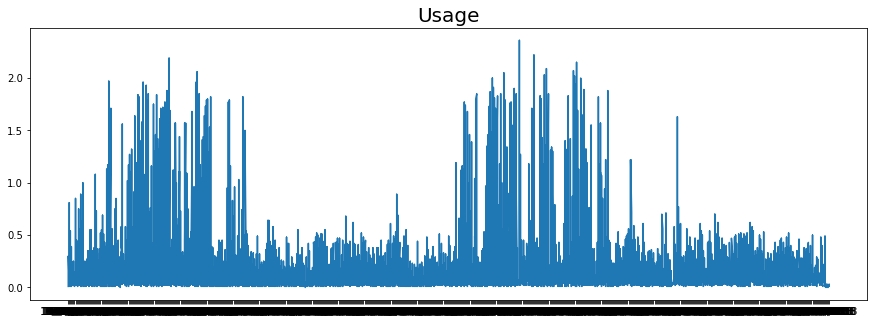

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(dates, usage)
plt.title('Usage',
          fontsize=20);

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(usage, dates, test_size=0.2)

In [65]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [66]:
tf.random.set_seed(51)
train_set = windowed_dataset(X_train, window_size=64, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(X_test, window_size=64, batch_size=100, shuffle_buffer=1000)

In [71]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [74]:
minMAE = (df['USAGE'].max() - df['USAGE'].min()) * (10/100)
minMAE

0.236

In [68]:
initial_learning_rate = 0.01
epochs = 20
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [72]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=20, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)], validation_data=validation_set)

Epoch 1/20
563/563 [==============================] - 26s 39ms/step - loss: 0.0211 - mae: 0.1037 - val_loss: 0.0220 - val_mae: 0.1132
Epoch 2/20
563/563 [==============================] - 21s 38ms/step - loss: 0.0203 - mae: 0.1117 - val_loss: 0.0220 - val_mae: 0.1142
Epoch 3/20
563/563 [==============================] - 21s 38ms/step - loss: 0.0203 - mae: 0.1120 - val_loss: 0.0220 - val_mae: 0.1142
Epoch 4/20
563/563 [==============================] - 21s 38ms/step - loss: 0.0203 - mae: 0.1120 - val_loss: 0.0220 - val_mae: 0.1142
Epoch 5/20
563/563 [==============================] - 22s 38ms/step - loss: 0.0203 - mae: 0.1120 - val_loss: 0.0220 - val_mae: 0.1142
Epoch 6/20
563/563 [==============================] - 21s 38ms/step - loss: 0.0203 - mae: 0.1121 - val_loss: 0.0220 - val_mae: 0.1142
Epoch 7/20
563/563 [==============================] - 21s 38ms/step - loss: 0.0203 - mae: 0.1120 - val_loss: 0.0220 - val_mae: 0.1143
Epoch 8/20
563/563 [==============================] - 22s 38ms

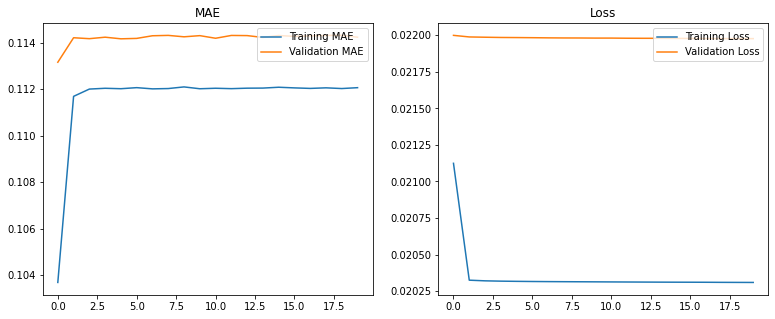

In [73]:
import matplotlib.pyplot as plt

mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(mae))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()